In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

import requests
import nltk
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
import unicodedata
import re
import pandas as pd
import numpy as np

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

from acquire import scrape_github_data, headers
from prepare import basic_clean, lemmatize, remove_stopwords, split

from wordcloud import WordCloud
from PIL import Image
from wordcloud import ImageColorGenerator
from jupyterthemes import jtplot
jtplot.style(grid=False)

[nltk_data] Downloading package stopwords to /Users/ken/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/ken/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
scraped_list = scrape_github_data()
df = pd.DataFrame(scraped_list)
df = df.drop_duplicates().dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 403 entries, 0 to 494
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repo             403 non-null    object
 1   language         403 non-null    object
 2   readme_contents  403 non-null    object
dtypes: object(3)
memory usage: 12.6+ KB


In [3]:
df = df.rename({'readme_contents':'original'},axis=1)
df['clean'] = df.original.apply(basic_clean)
df['lemmatized'] = df.clean.apply(lemmatize)
df['stopwords_removed'] = df.lemmatized.apply(remove_stopwords)
df.head()

repo    language  \
0      bitcoin/bitcoin         C++   
1            ccxt/ccxt  JavaScript   
2  freqtrade/freqtrade      Python   
3      DeviaVir/zenbot        HTML   
4      lbryio/lbry-sdk      Python   

                                            original  \
0  Bitcoin Core integration/staging tree\n=======...   
1  # CCXT – CryptoCurrency eXchange Trading Libra...   
2  # ![freqtrade](https://raw.githubusercontent.c...   
3  ![zenbot logo](assets/logo.png)\n\n> “To follo...   
4  # <img src="https://raw.githubusercontent.com/...   

                                               clean  \
0  bitcoin core integrationstaging tree\n\n\nhttp...   
1   ccxt  cryptocurrency exchange trading library...   
2   freqtradehttpsrawgithubusercontentcomfreqtrad...   
3  zenbot logoassetslogopng\n\n to follow the pat...   
4   img srchttpsrawgithubusercontentcomlbryiolbry...   

                                          lemmatized  \
0  bitcoin core integrationstaging tree httpsbitc...   
1  ccxt cryptocurrency exchange trading library b...   
2  freqtradehttpsrawgithubusercontentcomfreqtrade...   
3  zenbot logoassetslogopng to follow the path lo...   
4  img srchttpsrawgithubusercontentcomlbryiolbrys...   

                                   stopwords_removed  
0  bitcoin core integrationstaging tree httpsbitc...  
1  ccxt cryptocurrency exchange trading library b...  
2  freqtradehttpsrawgithubusercontentcomfreqtrade...  
3  zenbot logoassetslogopng follow path look mast...  
4  img srchttpsrawgithubusercontentcomlbryiolbrys...

In [4]:
all_words = ' '.join(df.stopwords_removed)
all_words = pd.Series(all_words.split())
all_words.value_counts().head(20)

run            1349
td             1118
use            1100
install         989
1               983
wallet          875
file            842
data            841
transaction     823
build           803
version         757
using           743
address         726
key             716
api             712
bitcoin         699
new             674
see             671
code            667
make            651
dtype: int64

In [5]:
top_30_crypto_bigrams = (pd.Series(nltk.ngrams(all_words, 2))
                      .value_counts()
                      .head(30))

crypto_bigrams = top_30_crypto_bigrams[6:]

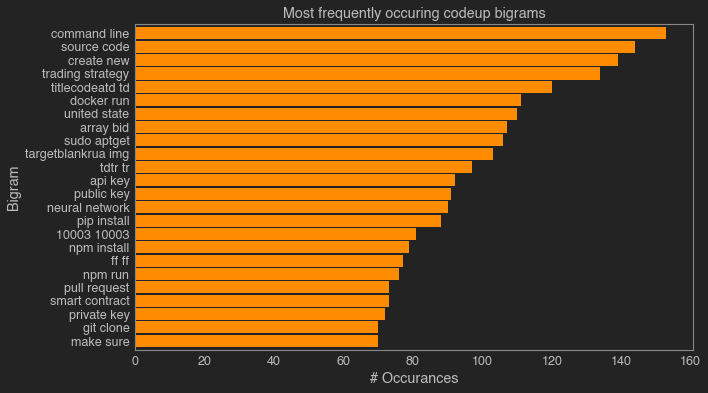

In [6]:
crypto_bigrams.sort_values().plot.barh(color='darkorange', width=.9, figsize=(10, 6))

plt.title('Most frequently occuring codeup bigrams')
plt.ylabel('Bigram')
plt.xlabel('# Occurances')

# make the labels pretty
ticks, _ = plt.yticks()
labels = crypto_bigrams.reset_index()['index'].apply(lambda t: t[0] + ' ' + t[1])
_ = plt.yticks(ticks, labels)

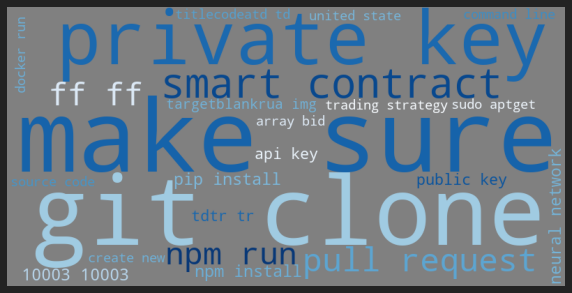

In [7]:
data = {k[0] + ' ' + k[1]: v for k, v in crypto_bigrams.to_dict().items()}
img = WordCloud(background_color='grey',colormap='Blues_r', width=800, height=400).generate_from_frequencies(data)
plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

In [8]:
df.language.value_counts().head()

Python        100
JavaScript     97
Go             36
C++            25
TypeScript     21
Name: language, dtype: int64

In [9]:
python = df[df.language == 'Python']
javascript = df[df.language == 'JavaScript']
go = df[df.language == 'Go']
cpp = df[df.language == 'C++']
typescript = df[df.language == 'TypeScript']

In [10]:
python_words = ' '.join(python.stopwords_removed)
cpp_words = ' '.join(cpp.stopwords_removed)
javascript_words = ' '.join(javascript.stopwords_removed)
go_words = ' '.join(go.stopwords_removed)
typescript_words = ' '.join(typescript.stopwords_removed)

In [11]:
python_freq = pd.Series(python_words.split()).value_counts()
cpp_freq = pd.Series(cpp_words.split()).value_counts()
javascript_freq = pd.Series(javascript_words.split()).value_counts()
go_freq = pd.Series(go_words.split()).value_counts()
typescript_freq = pd.Series(typescript_words.split()).value_counts()

python_freq.head()

python     460
install    334
data       317
key        287
use        264
dtype: int64

In [12]:
all_words = python_words + cpp_words + javascript_words + go_words + typescript_words
all_freq = pd.Series(all_words.split()).value_counts()

In [13]:
word_counts = (pd.concat([all_freq,python_freq,javascript_freq,go_freq,cpp_freq,typescript_freq], axis=1, sort=True)
                .set_axis(['all','python','javascript','go','c++','typescript'], axis=1, inplace=False)
                .fillna(0)
                .apply(lambda s: s.astype(int)))

word_counts.head()

all  python  javascript  \
'                                                    31      13          18   
''                                                   16      12           4   
'0'                                                   4       1           3   
'000000000'                                         185       0         185   
'0000000000b6288775bbd326bedf324ca8717a15191da5...    1       0           1   

                                                    go  c++  typescript  
'                                                    0    0           0  
''                                                   0    0           0  
'0'                                                  0    0           0  
'000000000'                                          0    0           0  
'0000000000b6288775bbd326bedf324ca8717a15191da5...   0    0           0

In [14]:
word_counts.sort_values(by='all', ascending=False).head(10)

all  python  javascript   go  c++  typescript
run          1037     249         366  186  107         129
install       812     334         260   78   83          57
1             775     209         425   64   60          17
td            761       5         756    0    0           0
use           753     264         259   94   83          53
wallet        618     231         170   66   60          91
transaction   606     145         200  178   49          34
data          588     317         149   77   29          16
file          549     147         154   99   90          59
python        536     460          36   18    8          14

Text(0.5, 1.0, 'Proportion of programming languages for the 20 most common words')

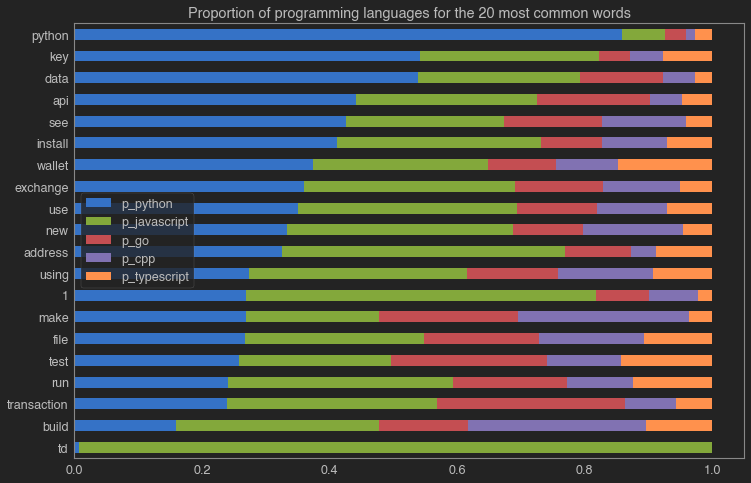

In [15]:
jtplot.style(grid=False,figsize=(15,10))
(word_counts
 .assign(p_python=word_counts.python / word_counts['all'],
         p_javascript=word_counts.javascript / word_counts['all'],
         p_go=word_counts.go / word_counts['all'],
         p_cpp=word_counts['c++'] / word_counts['all'],
         p_typescript=word_counts.typescript / word_counts['all'])
 .sort_values(by='all')
 [['p_python', 'p_javascript','p_go','p_cpp','p_typescript']]
 .tail(20)
 .sort_values('p_python')
 .plot.barh(stacked=True))

plt.title('Proportion of programming languages for the 20 most common words')

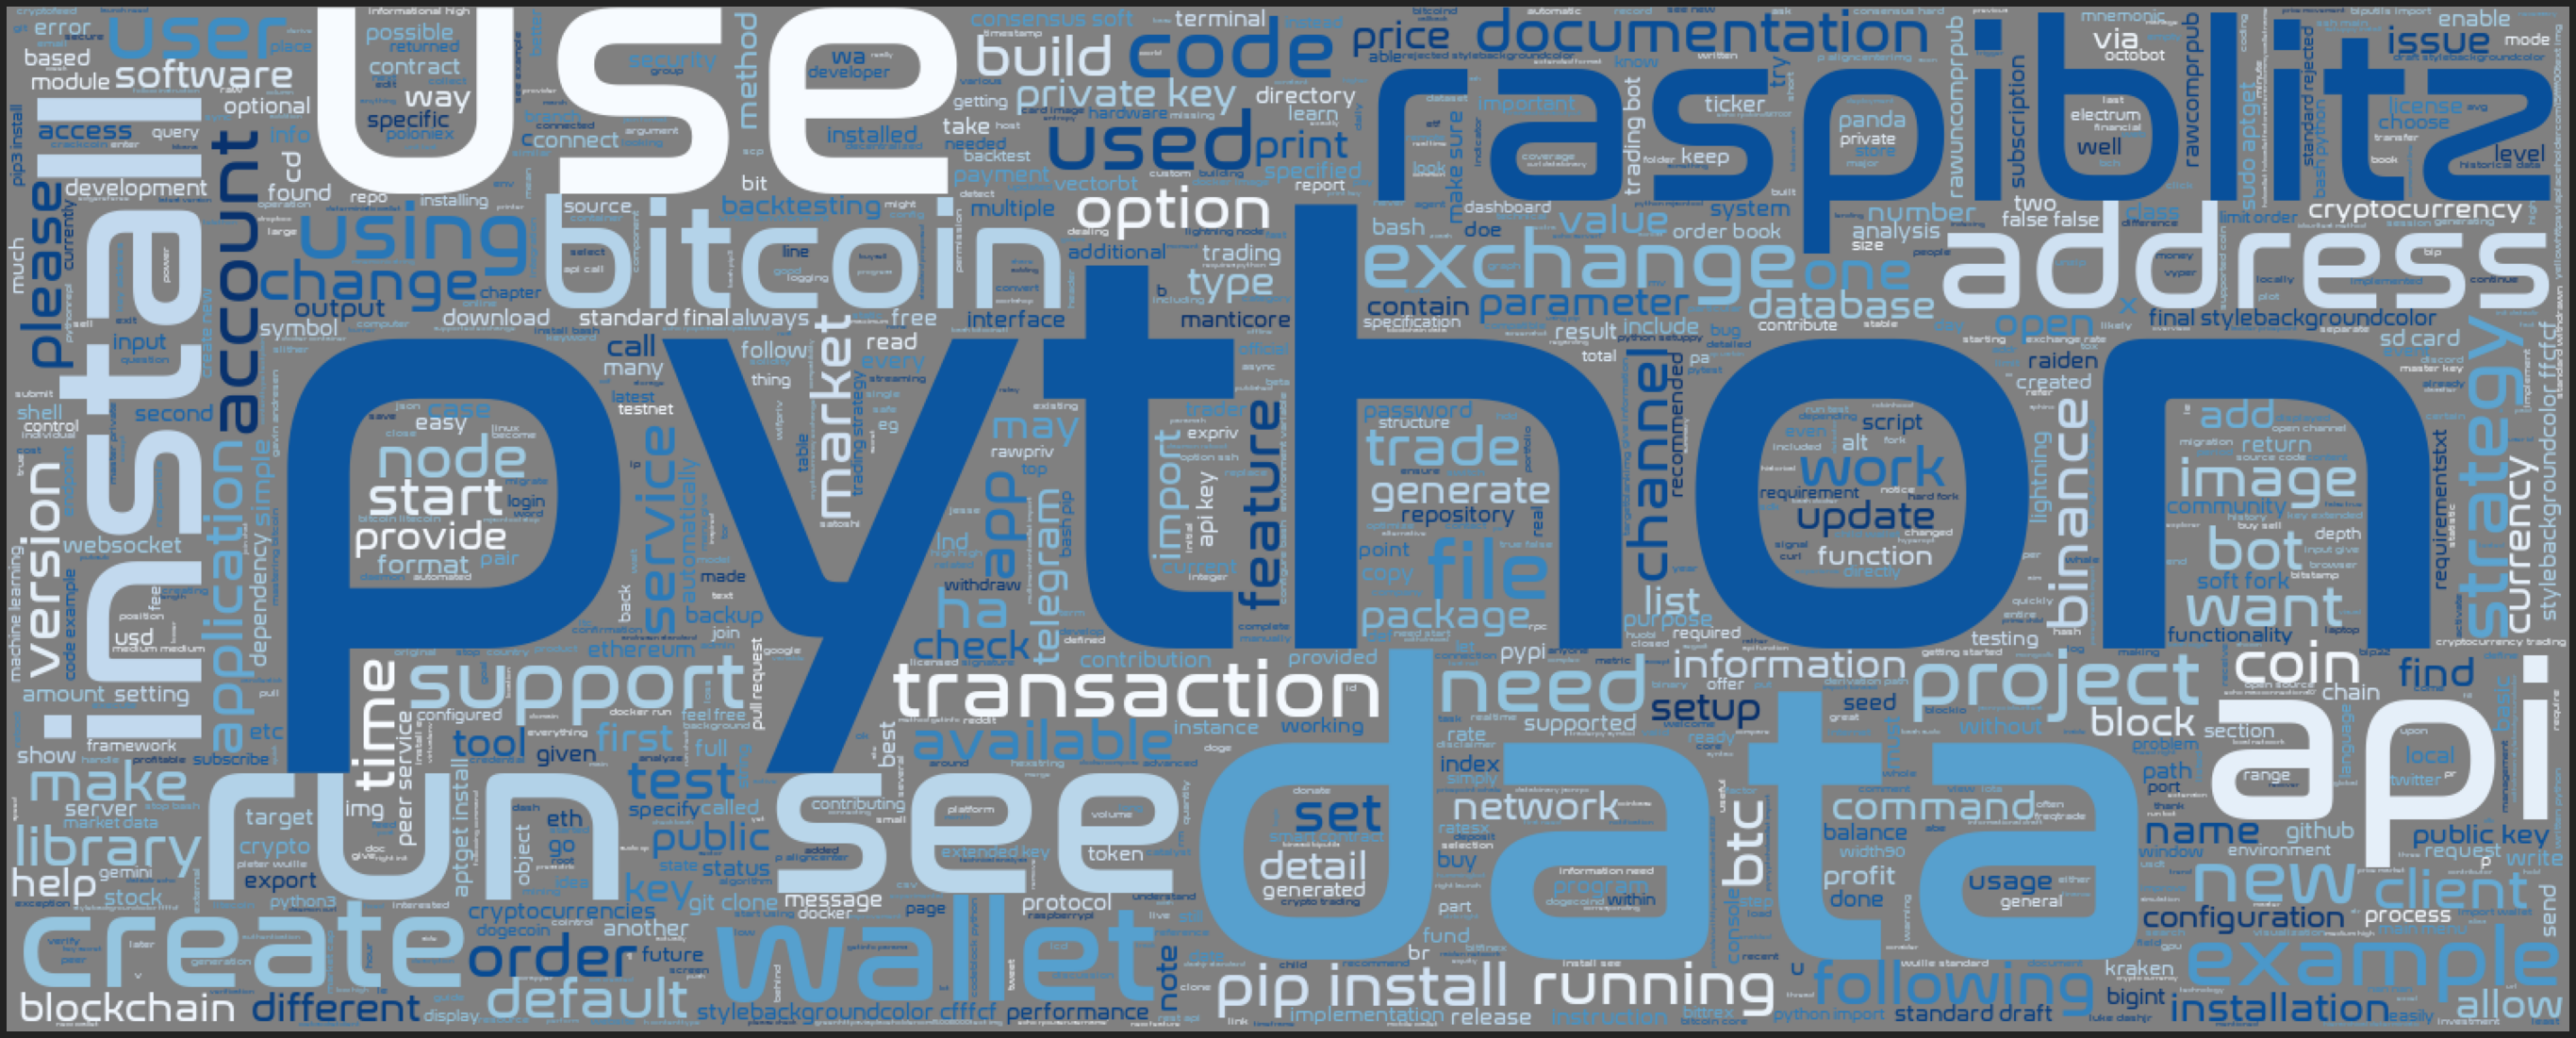

In [16]:
font_path = 'nasalization-rg.ttf'
python_cloud = WordCloud(max_words=None,font_path=font_path,background_color='grey', colormap='Blues', height=600, width=1500,random_state=123).generate(python_words)
plt.figure(figsize=(100,20))
plt.axis('off')
plt.imshow(python_cloud)

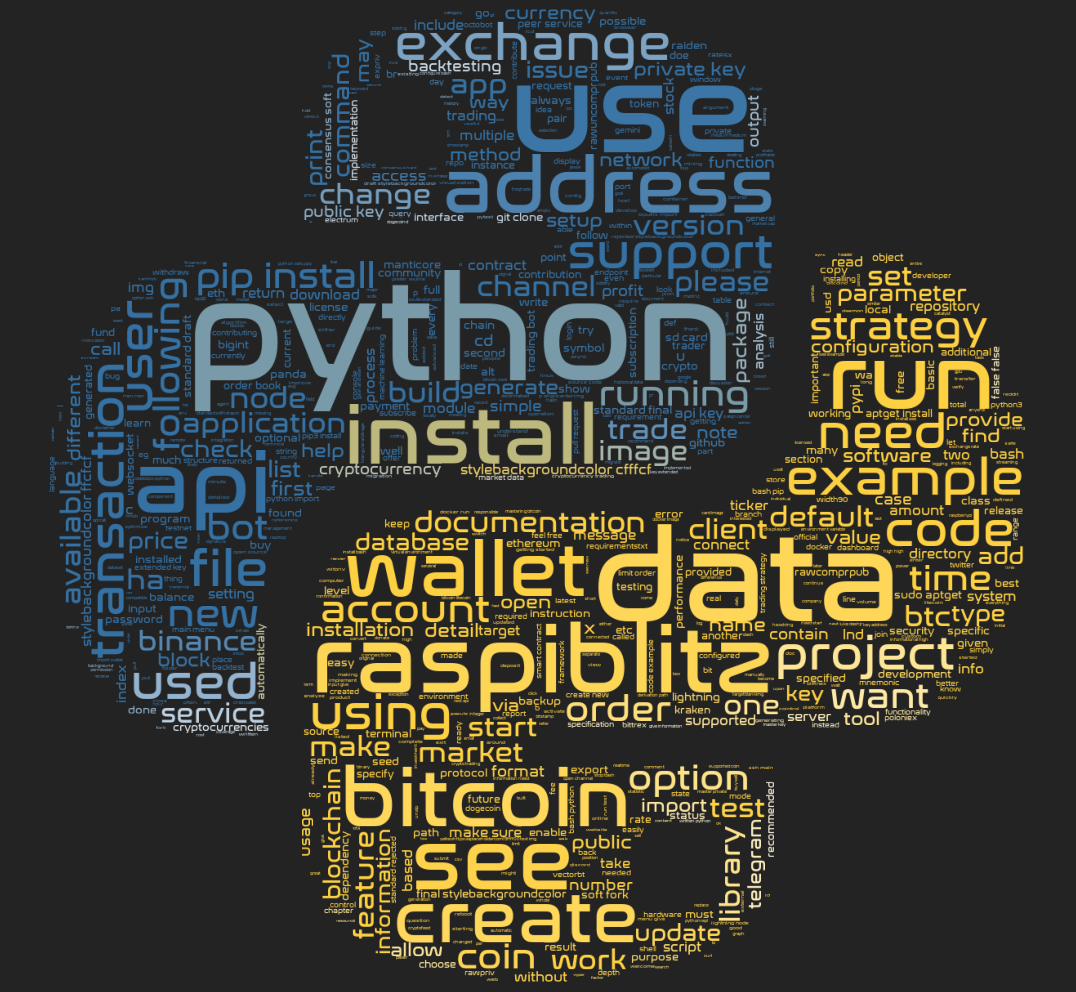

In [17]:
mask = np.array(Image.open('python copy.png'))
mask_colors = ImageColorGenerator(mask)
python_cloud = WordCloud(mask=mask,
                         width=mask.shape[1],
                         height=mask.shape[0],
                         max_words=5000,
                         font_path=font_path,
                         background_color=None,
                         mode='RGBA',
                         color_func=mask_colors,
                         random_state=45                         
                         #colormap='Blues',
                         ).generate(python_words)
plt.figure(figsize=(100, 18))
plt.axis('off')
plt.imshow(python_cloud)

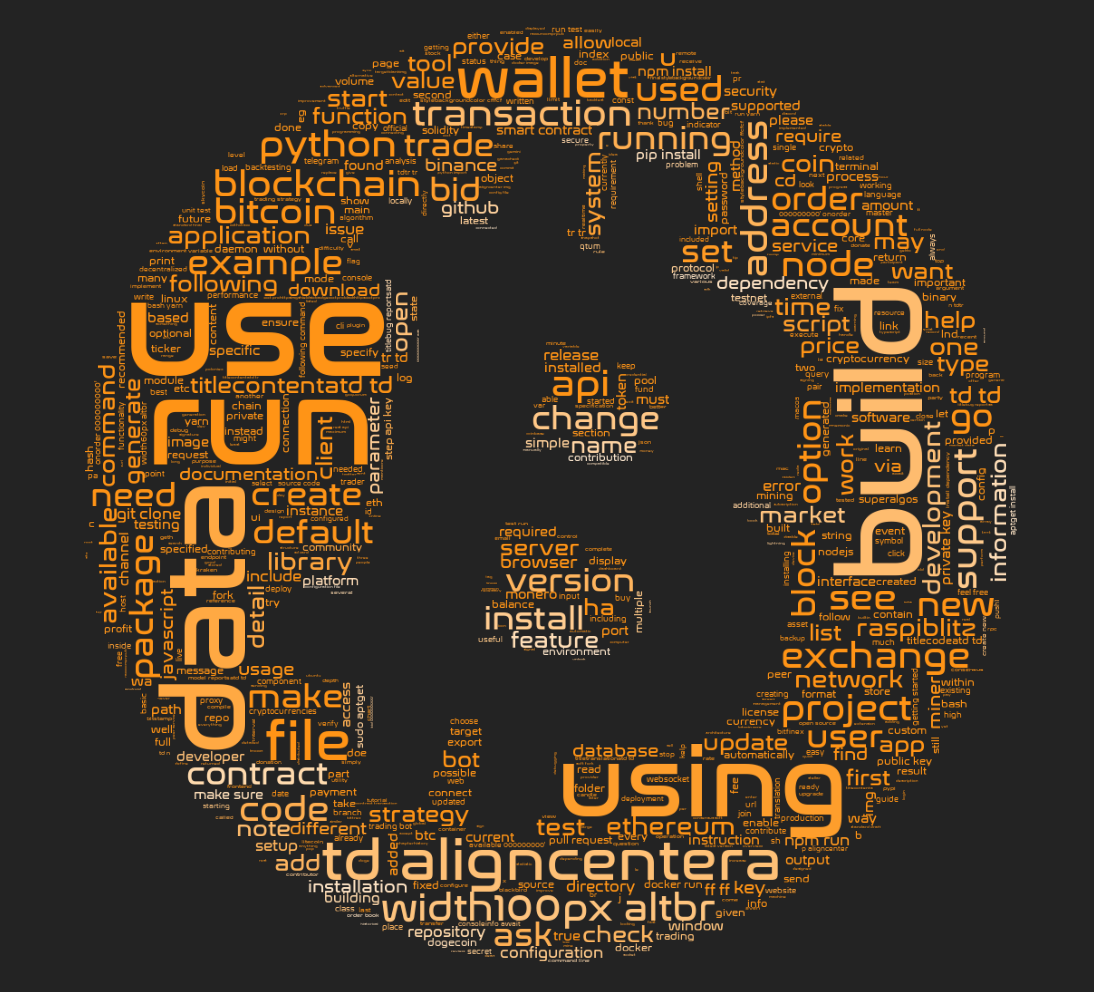

In [18]:
mask = np.array(Image.open('Bitcoin-Logo.png'))
mask_colors = ImageColorGenerator(mask)
all_cloud = WordCloud(mask=mask,
                         width=mask.shape[1],
                         height=mask.shape[0],
                         max_words=5000,
                         font_path=font_path,
                         background_color=None,
                         mode='RGBA',
                         color_func=mask_colors,
                         random_state=45                         
                         #colormap='Blues',
                         ).generate(all_words)
plt.figure(figsize=(100, 18))
plt.axis('off')
plt.imshow(all_cloud)

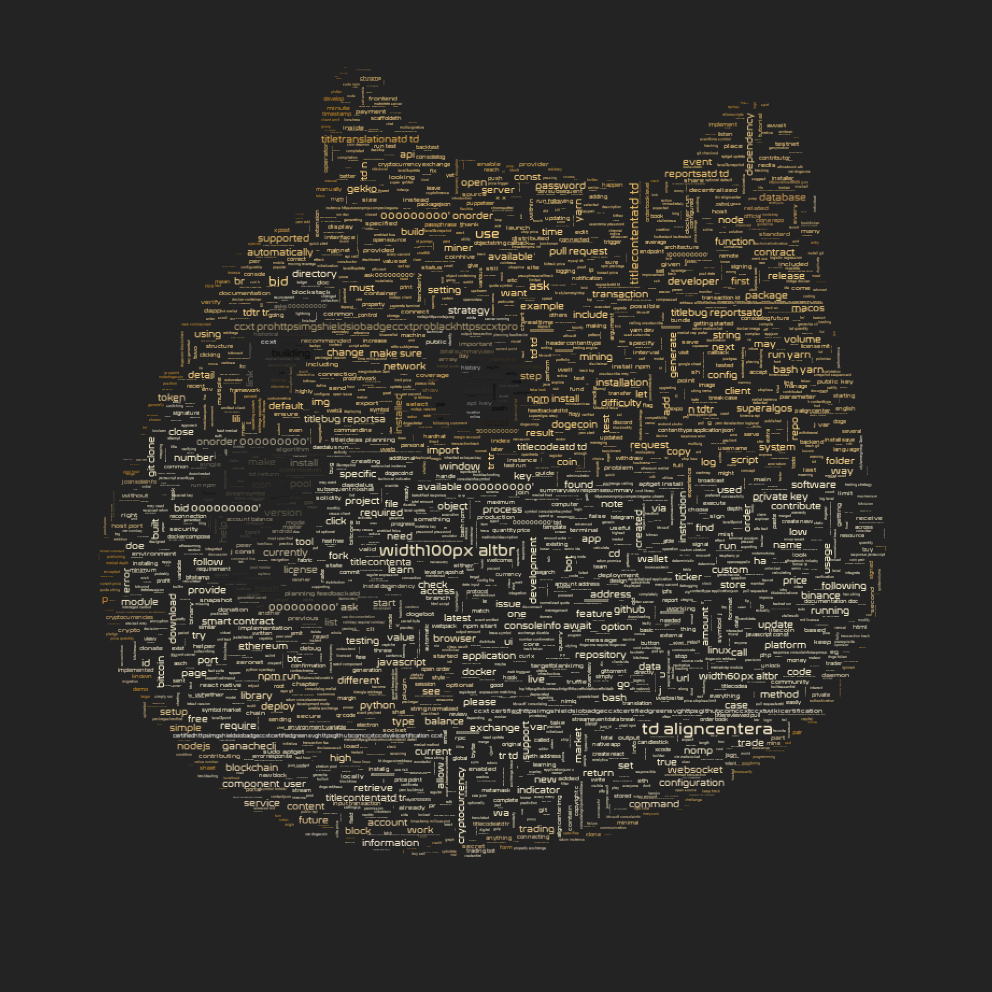

In [19]:
mask = np.array(Image.open('doge2 copy.png'))
mask_colors = ImageColorGenerator(mask)
doge_cloud = WordCloud(mask=mask,
                      width=mask.shape[1],
                      height=mask.shape[0],
                      max_words=None,
                      max_font_size=15,                      
                      font_path=font_path,
                      background_color=None,
                      color_func=mask_colors,
                      random_state=45,
                      mode='RGBA',
                      #margin=0.1,
                      min_font_size=2
                      # colormap='Blues',
                      ).generate(javascript_words)
plt.figure(figsize=(100, 18))
plt.axis('off')
plt.imshow(doge_cloud)

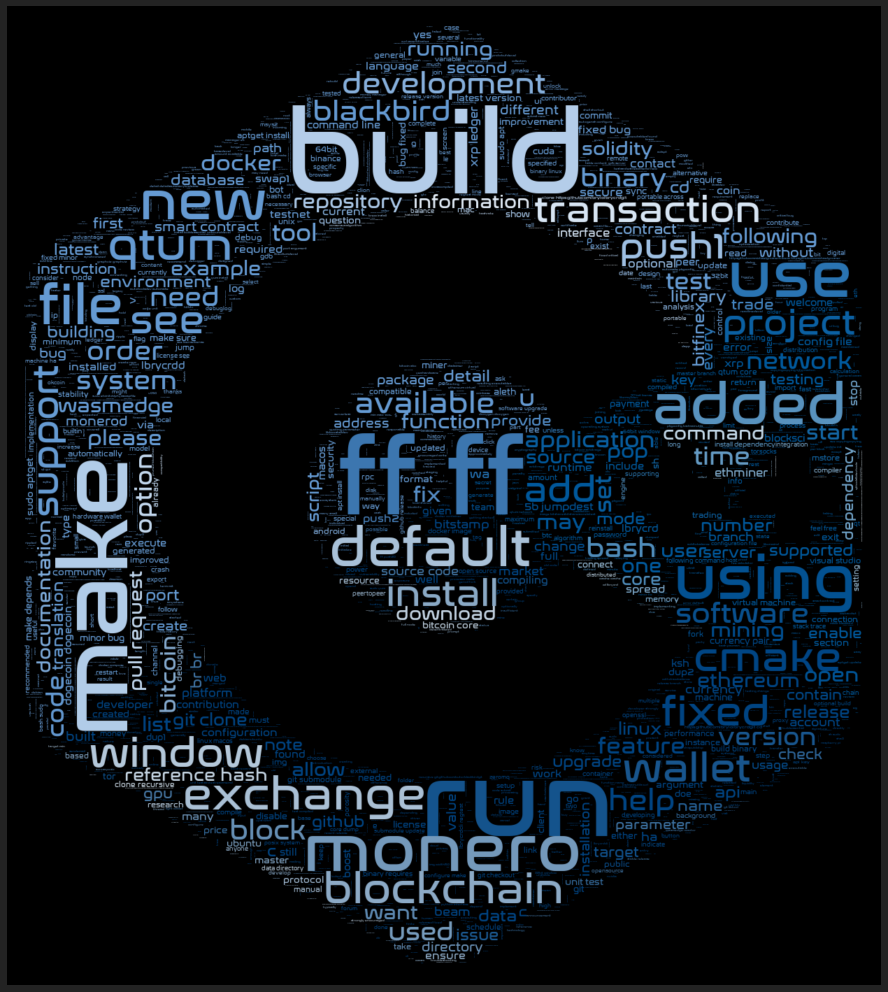

In [20]:
mask = np.array(Image.open('1200px-ISO_C++_Logo.png'))
mask_colors = ImageColorGenerator(mask)
cpp_cloud = WordCloud(mask=mask,
                         width=mask.shape[1],
                         height=mask.shape[0],
                         max_words=None,
                         font_path=font_path,
                         background_color='black',
                         mode='RGBA',
                         color_func=mask_colors,
                         random_state=45,
                         min_font_size=2
                         #colormap='Blues',
                         ).generate(cpp_words)
plt.figure(figsize=(100, 18))
plt.axis('off')
plt.imshow(cpp_cloud,interpolation="bilinear")

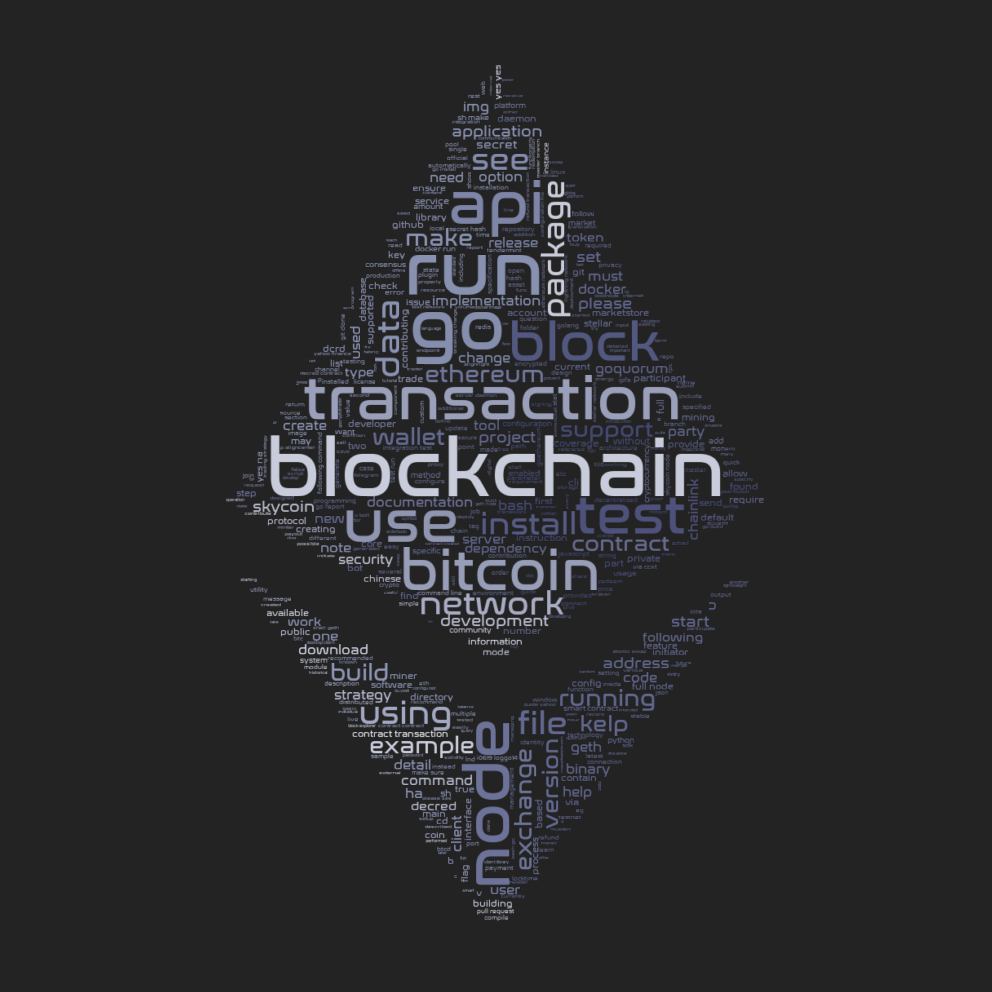

In [21]:
mask = np.array(Image.open('eth.png'))
mask_colors = ImageColorGenerator(mask)
eth_cloud = WordCloud(mask=mask,
                         width=mask.shape[1],
                         height=mask.shape[0],
                         max_words=None,
                         font_path=font_path,
                         background_color=None,
                         mode='RGBA',
                         color_func=mask_colors,
                         random_state=45,
                         #min_font_size=2
                         #colormap='Blues',
                         ).generate(go_words)
plt.figure(figsize=(100, 18))
plt.axis('off')
plt.imshow(eth_cloud,interpolation="bilinear")

In [22]:
top5 = ['Python','JavaScript','Go','C++','TypeScript']
model_df = df[df.language.isin(top5)][['repo','language','stopwords_removed']]
model_df.head()

repo    language  \
0        bitcoin/bitcoin         C++   
1              ccxt/ccxt  JavaScript   
2    freqtrade/freqtrade      Python   
4        lbryio/lbry-sdk      Python   
5  monero-project/monero         C++   

                                   stopwords_removed  
0  bitcoin core integrationstaging tree httpsbitc...  
1  ccxt cryptocurrency exchange trading library b...  
2  freqtradehttpsrawgithubusercontentcomfreqtrade...  
4  img srchttpsrawgithubusercontentcomlbryiolbrys...  
5  monero copyright c 20142021 monero project por...

In [24]:
train, validate, test = split(model_df,'language')
train.head()

repo    language  \
186              man-c/pycoingecko      Python   
309                  ethereum/mist  JavaScript   
304              ChainSafe/web3.js  JavaScript   
366    sammy007/open-ethereum-pool          Go   
468  blockstack/blockstack-browser  JavaScript   

                                     stopwords_removed  
186  coingecko api wrapper pypi versionhttpsimgshie...  
309  mist browser deprecated github releaseshttpsim...  
304  p aligncenter img srcassetslogoweb3jsjpg width...  
366  open source ethereum mining pool miner's stats...  
468  blockstack browser circleci branchhttpsimgshie...

In [25]:
#baseline
train['baseline'] = 'Python'
round((train.baseline == train.language).mean()*100,2)

35.9

In [26]:
# Setup our X variables
X_train = train.stopwords_removed
X_validate = validate.stopwords_removed
X_test = test.stopwords_removed

In [27]:
# Setup our y variables
y_train = train.language
y_validate = validate.language
y_test = test.language

In [28]:
X_train.head()

186    coingecko api wrapper pypi versionhttpsimgshie...
309    mist browser deprecated github releaseshttpsim...
304    p aligncenter img srcassetslogoweb3jsjpg width...
366    open source ethereum mining pool miner's stats...
468    blockstack browser circleci branchhttpsimgshie...
Name: stopwords_removed, dtype: object

In [29]:
# Create the tfidf vectorizer object
# Step 1, this creates a tf-idf values for each word, for each document
# Step 2, encodes these values so that we can use models that only work on numbers, like classifications model
tfidf = TfidfVectorizer()

# Fit on the training data
tfidf.fit(X_train)

# Use the object
X_train_vectorized = tfidf.transform(X_train)
X_validate_vectorized = tfidf.transform(X_validate)
X_test_vectorized = tfidf.transform(X_test)

In [30]:
X_train_vectorized.todense().shape

(156, 17098)

In [31]:
# Now that we have a vectorized dataset, we can use our classification tools!
lm = LogisticRegression(class_weight='balanced',solver='liblinear',random_state=123)

# Fit the classification model on our vectorized train data
lm.fit(X_train_vectorized, y_train)

LogisticRegression(class_weight='balanced', random_state=123,
                   solver='liblinear')

In [32]:
train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))
test = pd.DataFrame(dict(actual=y_test))

In [33]:
train.head()

actual
186      Python
309  JavaScript
304  JavaScript
366          Go
468  JavaScript

In [34]:
# Use the trained model to predict y given those vectorized inputs of X
train['predicted'] = lm.predict(X_train_vectorized)
validate["predicted"] = lm.predict(X_validate_vectorized)
test['predicted'] = lm.predict(X_test_vectorized)

In [35]:
train.head()

actual   predicted
186      Python      Python
309  JavaScript  JavaScript
304  JavaScript  JavaScript
366          Go          Go
468  JavaScript  JavaScript

In [36]:
# Train Accuracy
(train.actual == train.predicted).mean()

0.9935897435897436

In [37]:
# Out of sample accuracy
(validate.actual == validate.predicted).mean()

0.5522388059701493

In [38]:
#from sklearn.metrics import classification_report
print(classification_report(train.actual, train.predicted))

              precision    recall  f1-score   support

         C++       1.00      1.00      1.00        14
          Go       1.00      1.00      1.00        20
  JavaScript       1.00      0.98      0.99        54
      Python       0.98      1.00      0.99        56
  TypeScript       1.00      1.00      1.00        12

    accuracy                           0.99       156
   macro avg       1.00      1.00      1.00       156
weighted avg       0.99      0.99      0.99       156



In [39]:
test

actual   predicted
33          C++      Python
194          Go      Python
79   JavaScript  JavaScript
225      Python      Python
457      Python      Python
416  TypeScript  JavaScript
250  JavaScript  JavaScript
358  JavaScript  JavaScript
246  TypeScript      Python
226      Python      Python
217  JavaScript  JavaScript
475         C++      Python
191      Python      Python
25           Go          Go
37           Go      Python
62   JavaScript  JavaScript
205  JavaScript  JavaScript
61   JavaScript      Python
10           Go          Go
356  TypeScript  JavaScript
121      Python      Python
284      Python      Python
18       Python      Python
406      Python      Python
352  JavaScript  JavaScript
313         C++  JavaScript
404  JavaScript      Python
260  JavaScript      Python
68       Python      Python
227  JavaScript  JavaScript
340          Go      Python
240      Python      Python
19   JavaScript  JavaScript
484      Python      Python
293  JavaScript  JavaScript
51           Go      Python
177         C++      Python
64       Python      Python
233  JavaScript      Python
382  TypeScript  JavaScript
252  JavaScript  JavaScript
84   JavaScript      Python
221      Python      Python
187      Python      Python
328      Python      Python
238  JavaScript  JavaScript
9           C++  JavaScript
31   JavaScript  JavaScript
247      Python      Python
12       Python      Python
98   JavaScript  JavaScript
206      Python      Python
411      Python  JavaScript
481          Go  JavaScript
402  JavaScript      Python
413      Python      Python

In [40]:
print(classification_report(validate.actual, validate.predicted))

              precision    recall  f1-score   support

         C++       0.00      0.00      0.00         6
          Go       0.67      0.22      0.33         9
  JavaScript       0.54      0.57      0.55        23
      Python       0.55      0.92      0.69        24
  TypeScript       0.00      0.00      0.00         5

    accuracy                           0.55        67
   macro avg       0.35      0.34      0.31        67
weighted avg       0.47      0.55      0.48        67



In [41]:
print(classification_report(test.actual, test.predicted))

              precision    recall  f1-score   support

         C++       0.00      0.00      0.00         5
          Go       1.00      0.29      0.44         7
  JavaScript       0.67      0.70      0.68        20
      Python       0.58      0.95      0.72        20
  TypeScript       0.00      0.00      0.00         4

    accuracy                           0.62        56
   macro avg       0.45      0.39      0.37        56
weighted avg       0.57      0.62      0.56        56



# Linear support vector machine classifier

In [42]:
Encoder = LabelEncoder()
Train_Y = Encoder.fit_transform(y_train)
Validate_Y = Encoder.fit_transform(y_validate)
Test_Y = Encoder.fit_transform(y_test)

In [43]:
Tfidf_vect = TfidfVectorizer()
Tfidf_vect.fit(X_train)

Train_X_Tfidf = Tfidf_vect.transform(X_train)
Validate_X_Tfidf = Tfidf_vect.transform(X_validate)
Test_X_Tfidf = Tfidf_vect.transform(X_test)

In [44]:
print(Tfidf_vect.vocabulary_)

{'coingecko': 3177, 'api': 1459, 'wrapper': 16826, 'pypi': 12041, 'versionhttpsimgshieldsiopypivpycoingeckosvghttpspypipythonorgpypipycoingecko': 16356, 'githubhttpsimgshieldsiogithublicensemancpycoingecko': 6077, 'python3': 12056, 'around': 1610, 'coingeckohttpswwwcoingeckocom': 3179, 'v3': 16227, 'installation': 8730, 'bash': 1918, 'pip': 11426, 'install': 8728, 'pycoingecko': 12023, 'source': 13503, 'git': 6037, 'clone': 3082, 'httpsgithubcommancpycoingeckogit': 8062, 'cd': 2749, 'setuppy': 13212, 'usage': 16037, 'python': 12053, 'import': 8562, 'coingeckoapi': 3178, 'cg': 2812, 'example': 5257, 'required': 12582, 'parameter': 11209, 'endpoint': 4966, 'defined': 4110, 'mandatory': 9909, 'corresponding': 3679, 'function': 5803, 'optional': 10997, 'passed': 11239, 'using': 16121, 'name': 10472, 'doc': 4502, 'httpswwwcoingeckocomapidocsv3': 8323, 'list': 9604, 'supported': 14990, 'input': 8709, 'multiplevalued': 10412, 'commaseparated': 3284, 'eg': 4862, 'see': 13067, 'simpleprice': 13

In [45]:
print(Train_X_Tfidf)

  (0, 16826)	0.043149881281476433
  (0, 16775)	0.028312860958267145
  (0, 16533)	0.016939231532609417
  (0, 16460)	0.18993137215642283
  (0, 16444)	0.02713305316520326
  (0, 16441)	0.09142168284016114
  (0, 16356)	0.02713305316520326
  (0, 16227)	0.022497344057074462
  (0, 16121)	0.04081758489288808
  (0, 16102)	0.02713305316520326
  (0, 16075)	0.009218589099437919
  (0, 16065)	0.02879748101486236
  (0, 16056)	0.05426610633040652
  (0, 16054)	0.02713305316520326
  (0, 16050)	0.05426610633040652
  (0, 16049)	0.05426610633040652
  (0, 16047)	0.264948135667751
  (0, 16037)	0.04552447603257749
  (0, 15991)	0.021495784255249065
  (0, 15926)	0.015001592516557213
  (0, 15797)	0.03448444185352215
  (0, 15683)	0.09445974347484638
  (0, 15634)	0.05016343841224276
  (0, 15490)	0.02713305316520326
  (0, 15489)	0.015001592516557213
  :	:
  (155, 1705)	0.005285695772301439
  (155, 1676)	0.004978976869218109
  (155, 1660)	0.005717991786222655
  (155, 1657)	0.026428478861507194
  (155, 1652)	0.0240541

In [46]:
# Classifier - Algorithm - LinearSVC
# fit the training dataset on the classifier
SVM = svm.LinearSVC(class_weight='balanced',loss='hinge')

SVM.fit(Train_X_Tfidf,Train_Y)
# predict the labels on train dataset
predictions_SVM = SVM.predict(Train_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Train_Y)*100)

SVM Accuracy Score ->  99.35897435897436


In [47]:
predictions_SVM = SVM.predict(Validate_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Validate_Y)*100)

SVM Accuracy Score ->  50.74626865671642


In [48]:
predictions_SVM = SVM.predict(Test_X_Tfidf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, Test_Y)*100)

SVM Accuracy Score ->  75.0


In [49]:
print(classification_report(Test_Y, predictions_SVM))

              precision    recall  f1-score   support

           0       1.00      0.60      0.75         5
           1       0.71      0.71      0.71         7
           2       0.88      0.70      0.78        20
           3       0.66      0.95      0.78        20
           4       1.00      0.25      0.40         4

    accuracy                           0.75        56
   macro avg       0.85      0.64      0.68        56
weighted avg       0.80      0.75      0.74        56



In [50]:
#MVP model
print(classification_report(test.actual, test.predicted))

              precision    recall  f1-score   support

         C++       0.00      0.00      0.00         5
          Go       1.00      0.29      0.44         7
  JavaScript       0.67      0.70      0.68        20
      Python       0.58      0.95      0.72        20
  TypeScript       0.00      0.00      0.00         4

    accuracy                           0.62        56
   macro avg       0.45      0.39      0.37        56
weighted avg       0.57      0.62      0.56        56

